# Imports and Setup:

In [1]:
import os
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import torch
import torchvision
from einops import rearrange
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

import utils
from model import MAE_ViT

import warnings
warnings.filterwarnings('ignore')

# Load the Pretrained Model:

In [2]:
# define the model, dataset and pca mode
config_file_path = "../config/config_file.yaml"
cfg = utils.load_yaml(config_file_path)
dataset_name = cfg["MAE"]["dataset"]
pca_mode = cfg["MAE"]["pca_mode"]
model_name = cfg["MAE"]["model_name"]
folder_name = f"../model/{dataset_name}/{pca_mode}"
model_path = f"{folder_name}/{model_name}"
mask_ratio = cfg["MAE"]["mask_ratio"]
model = torch.load(model_path, map_location='cpu')
model.eval()
device = utils.get_gpu()
model.to(device)

Using Metal Performance Shaders framework (MPS)
0 Number of Devices Exists


MAE_ViT(
  (encoder): MAE_Encoder(
    (shuffle): PatchShuffle()
    (patchify): Conv2d(3, 192, kernel_size=(2, 2), stride=(2, 2))
    (transformer): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    

# Load Validation Dataset:

In [3]:
root_path = f"../data/{dataset_name}"
transform = Compose([ToTensor(), Normalize(0.5, 0.5)])

_, val_dataset = utils.load_and_preprocess_images(root_path, dataset_name, transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

Files already downloaded and verified


# Compute Validation Loss:

In [4]:
val_loss = 0
with torch.no_grad():
    for val_img, _ in val_dataloader:
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        loss = torch.mean((predicted_val_img - val_img) ** 2 * mask) / mask_ratio
        val_loss += loss.item()
val_loss /= len(val_dataloader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.0316


# Visualize the Predictions:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


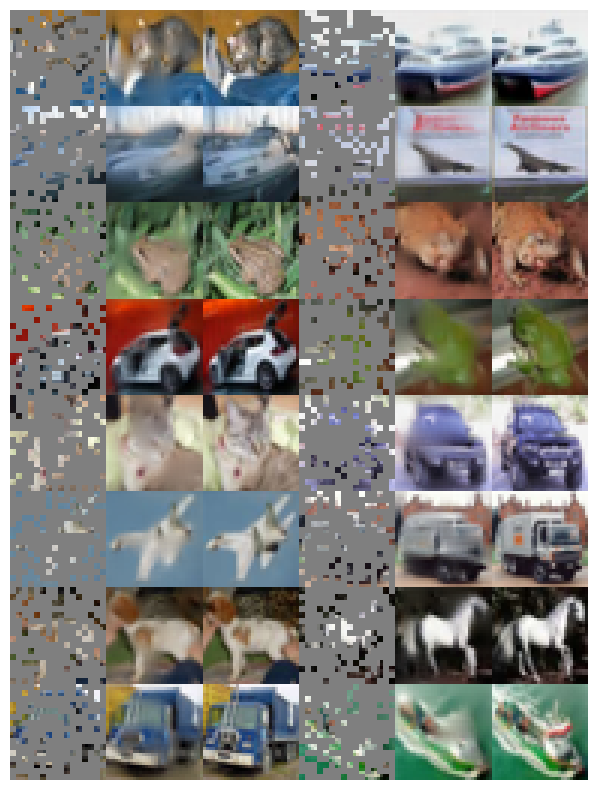

In [5]:
# Visualize the first batch
val_img, _ = next(iter(val_dataloader))
val_img = val_img.to(device)
predicted_val_img, mask = model(val_img)
predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)

img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
img = rearrange(img, "(v h1 w1) c h w -> c (h1 h) (w1 v w)", w1=2, v=3)

img = (
    img.cpu().detach().numpy().transpose(1, 2, 0) + 1
) / 2  # Normalize to [0, 1] for display

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()
folder_name = f"../images/model_results"
# create a folder to save the model if it does not exist
os.makedirs(folder_name, exist_ok=True)
plt.savefig(f"{folder_name}/mae_visualize.png")